# Q Learning Training Environment


For gray scale and thresholded 9x9 grid environment. 

In [1]:
import gym
# import gym_child
# #import gym_teen
import numpy as np
import time
import sys
import math
import random
import matplotlib.pyplot as plt

In [2]:
def get_explore_rate(t,min_explore_rate,decay_fact):
    return max(min_explore_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))


def get_learning_rate(t,min_learning_rate,decay_fact):
    return max(min_learning_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))

In [3]:
# variables: 
neps = 100
tstep = 200
min_explore_rate = 0.001
min_learning_rate = 0.2
#grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
#decay_fact = np.prod(grid_size, dtype=float) / 10.0
decay_fact = np.prod((9,9),dtype=float)/10.0
#state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
explore_rate = get_explore_rate(0,min_explore_rate,decay_fact)
learning_rate = get_learning_rate(0,min_learning_rate,decay_fact)

max_t = np.prod((9,9),dtype=int)*100
streak_to_end = 100
solved_t = np.prod((9,9),dtype=int)

In [4]:
def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action
    


In [5]:
def state_to_bucket(state,env):
    grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= state_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_bounds[i][1]:
            bucket_index = grid_size[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = state_bounds[i][1] - state_bounds[i][0]
            offset = (grid_size[i]-1)*state_bounds[i][0]/bound_width
            scaling = (grid_size[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)



In [6]:
def train_qlearn(env,q_table, explore_rate, learning_rate, neps=200,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((9,9),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((9,9),dtype=int)
    decay_fact = np.prod((9,9),dtype=float)/10.0
    num_steps = []
    episode_reward = []
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(5)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0.0

        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward
            #print('cur' + str(reward))
            #print(total_reward)
            #print(reward, total_reward)
            
            # update Q-table
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
            
            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.1)

            # update parameters
            #explore_rate = get_explore_rate(ep,min_explore_rate,decay_fact)
            #learning_rate = get_learning_rate(ep,min_learning_rate,decay_fact)
            
            if done:
                episode_reward.append(total_reward)
                num_steps.append(t+1)

                
                # plt.imshow(env.render())
                # plt.show()

                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table, num_steps, episode_reward

In [7]:
def test_qlearn(env,q_table, explore_rate, learning_rate, neps=100,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((9,9),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((9,9),dtype=int)
    decay_fact = np.prod((9,9),dtype=float)/10.0
    num_steps = []
    episode_reward = []
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(5)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0.0

        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward

            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.1)
            
            if done:
                episode_reward.append(total_reward)
                num_steps.append(t+1)

                
                # plt.imshow(env.render())
                # plt.show()

                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table, num_steps, episode_reward

## Comment out to build environment and Run Training and Testing

In [8]:
# Run Training 

# This is for no grid gray scale. 
# import gym_teen
# env = gym.make('maze-v0',height=60,width=60)
# env.set_target_xy(x = 162, y = 136)
# environment_type = "grayscale"
# #Make Q table
# q_table0 = np.zeros((405,405) + (4,), dtype=float)

# # still uses a 9x9 grid. 
import gym_child
env = gym.make('maze-v0')
#Make Q Table 
q_table0 = np.zeros((9,9) + (4,), dtype=float)
environment_type = "thresholded"

fin_q_table, train_num_steps, train_episode_reward  = train_qlearn(env,q_table0,explore_rate,learning_rate,neps=100,tstep=max_t)

print('Testing')
fin_q_table, test_num_steps, test_episode_reward = test_qlearn(env,fin_q_table, explore_rate, learning_rate, neps=100,tstep=max_t)
print('Complete')
env.render()
env.close()


pygame 2.1.2 (SDL 2.0.18, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
------------0
Episode 0 finished after 98.000000 time steps with total reward = -4749.520019 (streak 0).
------------1
Episode 1 finished after 102.000000 time steps with total reward = -4905.005689 (streak 0).
------------2
Episode 2 finished after 35.000000 time steps with total reward = -1657.897264 (streak 0).
------------3
Episode 3 finished after 74.000000 time steps with total reward = -3618.584616 (streak 1).
------------4
Episode 4 finished after 349.000000 time steps with total reward = -16943.843738 (streak 2).
------------5
Episode 5 finished after 43.000000 time steps with total reward = -2012.574637 (streak 0).
------------6
Episode 6 finished after 27.000000 time steps with total reward = -1315.310019 (streak 1).
------------7
Episode 7 finished after 125.000000 time steps with total reward = -6062.789044 (streak 2).
------------8


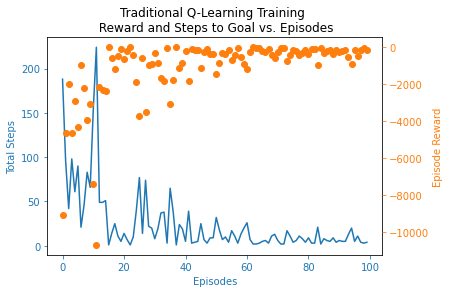

In [ ]:
# pickle load 
with open('parrot.pkl', 'rb') as f:
    mynewlist = pickle.load(f)

In [ ]:
import pickle
# pickle save 
with open(f'Traditional_Grid_Q_100_eps_decay_10_overfitting.pkl', 'wb') as f:
    pickle.dump(train_num_steps, f)

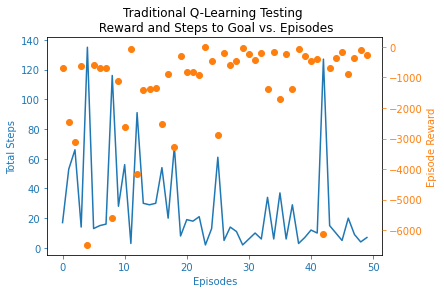

In [ ]:
length = len(test_num_steps[0:50])
fig = plt.figure()
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)
ax.plot(range(length), test_num_steps[0:50], color="C0")
ax.set_xlabel("Episodes", color="C0")
ax.set_ylabel("Total Steps", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax2.scatter(range(length), test_episode_reward[0:50], color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Episode Reward', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.set_title("Traditional Q-Learning Testing \n Reward and Steps to Goal vs. Episodes")
fig.savefig(f"Grayscale_distance_Traditional_Q_learn_testing_{length}eps_1_{environment_type}_eps_decay_100")

# Plot a Q-table, works best for 9x9 grid. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#### ACTION = ["N", "S", "E", "W"]

<AxesSubplot:>

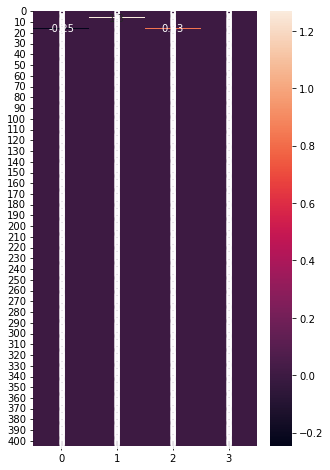

In [ ]:
fig,ax = plt.subplots(figsize=(5,8))
sns.heatmap(q_table0[4,:,:],annot=True)